 # Export phase energies as a table

This snippet can be used to export the results of a calculation to a Pandas `DataFrame` object.

In [1]:
from pycalphad import Workspace, variables as v
from pycalphad.property_framework.metaproperties import IsolatedPhase
import pandas as pd

wks = Workspace('alzn_mey.tdb', ['AL', 'ZN'],
                ['FCC_A1', 'HCP_A3', 'LIQUID'],
                {v.X('ZN'):(0,1,0.02), v.T: (300, 1000, 10), v.P:101325, v.N: 1})

props = [v.T, v.X('AL'), v.X('ZN')]
for phase_name in wks.phases:
    prop = IsolatedPhase(phase_name, wks)(f'GM({phase_name})')
    prop.display_name = f'GM({phase_name})'
    props.append(prop)

data = {f'{key.display_name} [{key.display_units}]': value.reshape(-1)
        for key, value in wks.get_dict(*props).items()}

pd.DataFrame(data)

,Temperature [kelvin],X_AL [fraction],X_ZN [fraction],GM(FCC_A1) [J / mol],GM(HCP_A3) [J / mol],GM(LIQUID) [J / mol]
0,300.0,1.00,1.000000e-10,-8496.605675,-3555.605675,-1043.275310
1,300.0,0.98,2.000000e-02,-8564.717990,-3674.761325,-1250.180921
2,300.0,0.96,4.000000e-02,-8573.037243,-3733.289523,-1394.468476
3,300.0,0.94,6.000000e-02,-8564.854312,-3774.752790,-1519.171542
4,300.0,0.92,8.000000e-02,-8549.523829,-3808.760080,-1633.419774
...,...,...,...,...,...,...
3495,990.0,0.10,9.000000e-01,-54233.504407,-54769.630291,-58354.955825
3496,990.0,0.08,9.200000e-01,-54199.685094,-54895.795230,-58409.376195
3497,990.0,0.06,9.400000e-01,-54123.191596,-54986.670187,-58424.306318
3498,990.0,0.04,9.600000e-01,-53989.616338,-55028.419738,-58385.478971


# Plot energy curves for several phases

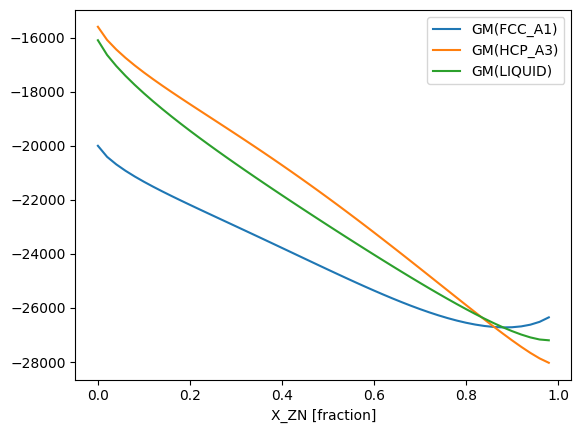

In [2]:
from pycalphad import Workspace, variables as v
from pycalphad.property_framework.metaproperties import IsolatedPhase
import matplotlib.pyplot as plt

wks2 = Workspace('alzn_mey.tdb', ['AL', 'ZN'],
                ['FCC_A1', 'HCP_A3', 'LIQUID'],
                {v.X('ZN'):(0,1,0.02), v.T: 600, v.P:101325, v.N: 1})

fig = plt.figure()
ax = fig.add_subplot()

x = wks2.get(v.X('ZN'))
ax.set_xlabel(f"{v.X('ZN').display_name} [{v.X('ZN').display_units}]")

for phase_name in wks2.phases:
    # Workaround for poor starting point selection in IsolatedPhase
    metastable_wks = wks2.copy()
    metastable_wks.phases = [phase_name]
    prop = IsolatedPhase(phase_name, metastable_wks)(f'GM({phase_name})')
    prop.display_name = f'GM({phase_name})'
    ax.plot(x, wks2.get(prop), label=prop.display_name)
ax.legend()

# Driving force calculation

Text(0, 0.5, 'Liquid Driving Force [J / mol]')

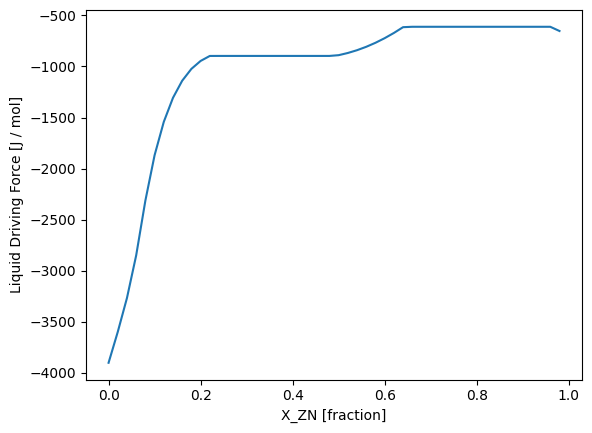

In [3]:
from pycalphad import Workspace, variables as v
from pycalphad.property_framework.metaproperties import DormantPhase

wks3 = Workspace('alzn_mey.tdb', ['AL', 'ZN'],
                ['FCC_A1', 'HCP_A3', 'LIQUID'],
                {v.X('ZN'):(0,1,0.02), v.T: 600, v.P:101325, v.N: 1})
metastable_liq_wks = wks3.copy()
metastable_liq_wks.phases = ['LIQUID']
liq_driving_force = DormantPhase('LIQUID', metastable_liq_wks).driving_force
liq_driving_force.display_name = 'Liquid Driving Force'

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(wks3.get(v.X('ZN')), wks3.get(liq_driving_force))
ax.set_xlabel(f"{v.X('ZN').display_name} [{v.X('ZN').display_units}]")
ax.set_ylabel(f"{liq_driving_force.display_name} [{liq_driving_force.display_units}]")

# Calculate T0 (t-zero) as a function of composition

The T0 (t-zero) temperature is a thermodynamic condition in which two specified phases have the same value of the Gibbs energy. Below T0, a so-called "massive" phase transition is thermodynamically favored to occur, without a barrier to diffusion.

Text(0, 0.5, 'T0(FCC_A1,HCP_A3) [kelvin]')

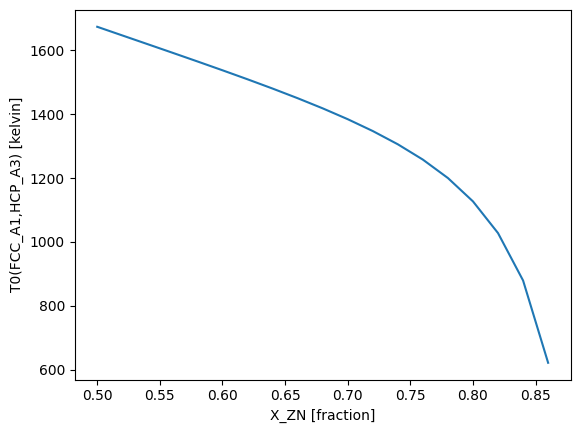

In [4]:
from pycalphad.property_framework.tzero import T0

# For T0, conditions must be one-dimensional (step calculation)
wks4 = Workspace('alzn_mey.tdb', ['AL', 'ZN'],
                ['FCC_A1', 'HCP_A3', 'LIQUID'],
                {v.X('ZN'): (0,1,0.02), v.T: 300, v.P:101325, v.N: 1})
tzero = T0('FCC_A1', 'HCP_A3', wks4)
tzero.maximum_value = 1700 # set temperature limit

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(wks4.get(v.X('ZN')), wks4.get(tzero))
ax.set_xlabel(f"{v.X('ZN').display_name} [{v.X('ZN').display_units}]")
ax.set_ylabel(f"{tzero} [{tzero.display_units}]")